# Problem 11.2

**Integrated Energy Grids**

**Problem 11.2. Join capacity and dispatch optimization.**

**Create a model in PyPSA and optimize the capacity and dispatch of solar PV, onshore wind and battery storage to supply the inelastic electricity demand throughout the year, including demand assuming full electrification of land transport.  To do this, take the time series for the [wind](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and [solar](https://zenodo.org/record/2613651#.X0kbhDVS-uV) capacity factors for Portugal in 2015 and the [electricity demand](https://github.com/martavp/integrated-energy-grids/tree/main/integrated-energy-grids/Problems/data).**


**Assume that the 5.6 million cars currently existing in Portugal are replaced by electric vehicles (EVs), with an average EV battery capacity of 50 kWh and a charging capacity of 11 kV.  The time series for [EV electricity demand](https://github.com/martavp/integrated-energy-grids/tree/main/integrated-energy-grids/Problems/data) can be found in the course repository.**

 
**a) If EV batteries are assumed to be charged right after the cars are used, calculate the required capacity and generation mix for the optimal system. Plot the energy generation and demand throughout July 1st. The EVs can only be charged when they are parked, and this can be represented by the [availability profile](https://github.com/martavp/integrated-energy-grids/tree/main/integrated-energy-grids/Problems/data).**


:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install `pandas` and `numpy` by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pandas pypsa
```
:::

In [198]:
import matplotlib.pyplot as plt
import pandas as pd
import pypsa

## Prerequisites: handling technology data and costs

We maintain a database (https://github.com/PyPSA/technology-data) which collects assumptions and projections for energy system technologies (such as costs, efficiencies, lifetimes, etc.) for given years, which we can load into a `pandas.DataFrame`. This requires some pre-processing to load (e.g. converting units, setting defaults, re-arranging dimensions):

In [199]:
year = 2030
url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
costs = pd.read_csv(url, index_col=[0, 1])

In [200]:
costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

Let's also write a small utility function that calculates the **annuity** to annualise investment costs. The formula is

$$
a(r, n) = \frac{r}{1-(1+r)^{-n}}
$$
where $r$ is the discount rate and $n$ is the lifetime.

In [201]:
def annuity(r, n):
    return r / (1.0 - 1.0 / (1.0 + r) ** n)

In [202]:
annuity(0.07, 20)

0.09439292574325567

Based on this, we can calculate the marginal generation costs (€/MWh):

In [203]:
costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]

and the annualised investment costs (`capital_cost` in PyPSA terms, €/MW/a):

In [204]:
annuity = costs.apply(lambda x: annuity(x["discount rate"], x["lifetime"]), axis=1)

In [205]:
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

We can now read the capital and marginal cost of onshore wind and solar.

In [206]:
costs.at["onwind", "capital_cost"] #EUR/MW/a

101644.12332388277

In [207]:
costs.at["solar", "capital_cost"] #EUR/MW/a

51346.82981964593

## Retrieving time series data

In this example, wind data from [https://zenodo.org/record/3253876#.XSiVOEdS8l0](https://zenodo.org/record/3253876#.XSiVOEdS8l0) and solar PV data from [https://zenodo.org/record/2613651#.X0kbhDVS-uV](https://zenodo.org/record/3253876#.XSiVOEdS8l0) is used. The data is downloaded in csv format and saved in the 'data' folder.
The Pandas package is used as a convenient way of managing the datasets.

For convenience, the column including date information is converted into Datetime and set as index

In [208]:
data_solar = pd.read_csv('data/pv_optimal.csv',sep=';')
data_solar.index = pd.DatetimeIndex(data_solar['utc_time'])

data_wind = pd.read_csv('data/onshore_wind_1979-2017.csv',sep=';')
data_wind.index = pd.DatetimeIndex(data_wind['utc_time'])

data_el = pd.read_csv('data/electricity_demand.csv',sep=';')
data_el.index = pd.DatetimeIndex(data_el['utc_time'])

data_el_EV = pd.read_csv('data/EV_electricity_demand.csv',sep=';')
data_el_EV.index = pd.DatetimeIndex(data_el_EV['utc_time'])

The data format can now be analyzed using the .head() function to show the first lines of the data set

In [209]:
data_el_EV.head()

,utc_time,PRT
utc_time,,
2015-01-01 00:00:00+00:00,2015-01-01T00:00:00Z,703.395764
2015-01-01 01:00:00+00:00,2015-01-01T01:00:00Z,474.707583
2015-01-01 02:00:00+00:00,2015-01-01T02:00:00Z,359.721755
2015-01-01 03:00:00+00:00,2015-01-01T03:00:00Z,344.947896
2015-01-01 04:00:00+00:00,2015-01-01T04:00:00Z,436.246018


We will use timeseries for Portugal in this excercise

In [210]:
country = 'PRT'

### Join capacity and dispatch optimization

For building the model, we start again by initialising an empty network, adding the snapshots, the electricity and the EV bus.

In [211]:
n = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

n.set_snapshots(hours_in_2015.values)

n.add("Bus", "electricity")
n.add("Bus", "EV")


Index(['EV'], dtype='object')

Next, we add the demand time series to the model.

In [212]:
# add load to the bus
n.add("Load",
      "electricity demand",
      bus="electricity",
      p_set=data_el[country].values)

Index(['electricity demand'], dtype='object')

We can add now the electricity demand from EVs and check that it was properly added.

<Axes: xlabel='snapshot', ylabel='MW'>

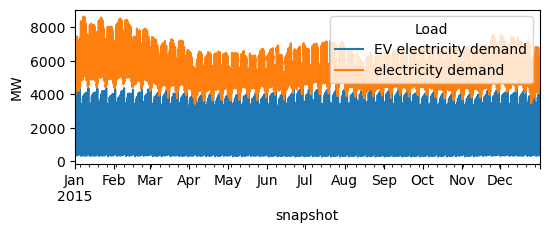

In [213]:
# add load to the bus
n.add("Load",
      "EV electricity demand",
      bus="EV",
      p_set=data_el_EV[country].values)

n.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

We add now the generators and set up their capacities to be extendable so that they can be optimized together with the dispatch time series. For the wind and solar generator, we need to indicate the capacity factor or maximum power per unit 'p_max_pu'

In [214]:
CF_wind = data_wind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "onwind",
        bus="electricity",
        carrier="onwind",
        p_max_pu=CF_wind.values,
        capital_cost=costs.at["onwind", "capital_cost"],
        marginal_cost=costs.at["onwind", "marginal_cost"],
        efficiency=costs.at["onwind", "efficiency"],
        p_nom_extendable=True,
    )

CF_solar = data_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in n.snapshots]]
n.add(
        "Generator",
        "solar",
        bus="electricity",
        carrier="solar",
        p_max_pu= CF_solar.values,
        capital_cost=costs.at["solar", "capital_cost"],
        marginal_cost=costs.at["solar", "marginal_cost"],
        efficiency=costs.at["solar", "efficiency"],
        p_nom_extendable=True,
    )

Index(['solar'], dtype='object')

So let's make sure the capacity factors are read-in correctly.

<Axes: xlabel='snapshot', ylabel='CF'>

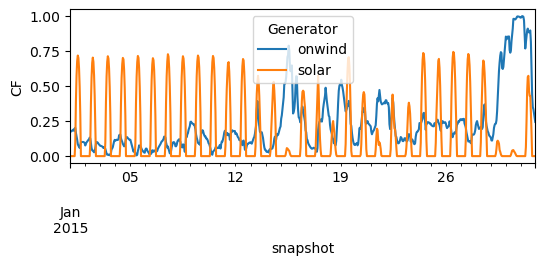

In [215]:
n.generators_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="CF")

We add the battery storage, assuming a fixed energy-to-power ratio of 2 hours, i.e. if fully charged, the battery can discharge at full capacity for 2 hours. 

For capital costs, we have to factor in both the capacity and energy costs of storage. 

We include the charging and discharging efficiencies we enforce a cyclic state-of-charge condition, i.e. the state of charge at the beginning of the optimisation period must equal the final state of charge.

In [216]:
n.add(
    "StorageUnit",
    "battery storage",
    bus="electricity",
    carrier="battery storage",
    max_hours=2,
    capital_cost=costs.at["battery inverter", "capital_cost"]
    + 6 * costs.at["battery storage", "capital_cost"],
    efficiency_store=costs.at["battery inverter", "efficiency"],
    efficiency_dispatch=costs.at["battery inverter", "efficiency"],
    p_nom_extendable=True,
    cyclic_state_of_charge=True,
)

Index(['battery storage'], dtype='object')

The electric vehicles can only be charged when they are plugged-in. Below we load an availability profile telling us what share of electric vehicles is plugged-in at home -- we only assume home charging in this example.


Then, we can add a link for the electric vehicle charger using an assumption about the number of EVs and their charging capacity

<Axes: xlabel='snapshot', ylabel='availability'>

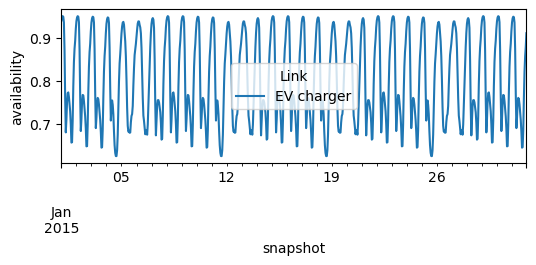

In [217]:
EV_availability_profile = pd.read_csv('data/EV_availability.csv',sep=';')
EV_availability_profile.index = pd.DatetimeIndex(EV_availability_profile['utc_time'])

number_cars = 5600000 #  number of EV cars
bev_charger_rate = 0.011  # 11 kW -> MW
p_nom = number_cars * bev_charger_rate

n.add(
    "Link",
    "EV charger",
    bus0="electricity",
    bus1="EV",
    p_nom=p_nom,
    p_max_pu=EV_availability_profile['PRT'].values,
    efficiency=0.9,
)

n.links_t.p_max_pu.loc["2015-01"].plot(figsize=(6, 2), ylabel="availability")

### Model Run

We can already solved the model using the open-solver "highs" or the commercial solver "gurobi" with the academic license

In [218]:
n.optimize(solver_name="highs")

Index(['electricity', 'EV'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='StorageUnit')
Index(['onwind', 'solar'], dtype='object', name='Generator')
Index(['EV charger'], dtype='object', name='Link')
Index(['electricity', 'EV'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='StorageUnit')
Index(['onwind', 'solar'], dtype='object', name='Generator')
Index(['EV charger'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:01<00:00,  4.12it/s]
INFO:linopy.io: Writing time: 12.11s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 52563 primals, 131403 duals
Objective: 1.32e+10
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link

('ok', 'optimal')

Now, we can look at the results and evaluate the total system cost (in billion Euros per year) and per MWh

In [219]:
n.objective / 1e9

13.199463807945415

In [220]:
n.objective/n.loads_t.p_set.sum().sum()

193.03886693959194

The optimised capacities in GW

In [221]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

Generator
onwind    38.917551
solar     75.751172
Name: p_nom_opt, dtype: float64

And the optimised static battery capacity 

In [222]:
n.storage_units.max_hours*n.storage_units.p_nom_opt.div(1e3) #MWh - GWh

StorageUnit
battery storage    104.753029
dtype: float64

The total energy generation by technology in TWh:

In [223]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

Generator
onwind     6.055918
solar     66.951797
dtype: float64

We can plot the dispatch of electricity from every generator throughout January 1st.

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16'),
 Text(17, 0, '17'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '20'),
 Text(21, 0, '21'),
 Text(22, 0, '22'),
 Text(23, 0, '23')]

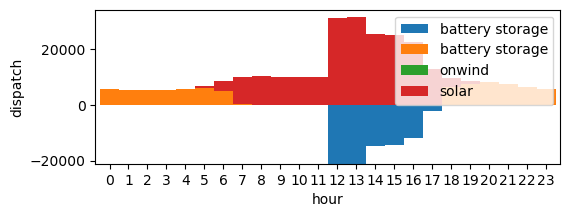

In [224]:
date="2015-07-01"
charge = n.storage_units_t.p['battery storage'][n.storage_units_t.p['battery storage']>0].loc[date]
discharge = n.storage_units_t.p['battery storage'][n.storage_units_t.p['battery storage']<0].loc[date]
combined =  pd.concat([discharge, charge, n.generators_t.p.loc[date]], axis=1)

ax = combined.plot.bar(figsize=(6, 2), ylabel="dispatch", xlabel="hour", stacked=True, width=1)
ax.legend(loc='upper right')
ax.set_xticks(range(len(combined.index)))  
ax.set_xticklabels(combined.index.hour, rotation=0) 

We can also plot the annual electricity mix

<Axes: title={'center': 'Electricity'}>

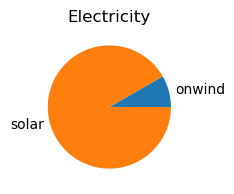

In [225]:
n.generators_t.p.sum().plot.pie(figsize=(6, 2), title='Electricity')

**b) Assume that the EV batteries can be charge when it is optimal for the system (smart-charging). How do the required capacities change relative to section (a)? Plot the energy generation and demand throughout July 1st.** 

To represent the fact that the EV battery can be charged at any time that is convenient for the system (smart-charging), we add a battery to the EV bus. 
The energy capacity of that battery is based on the number of vehicles and the assumption of 50 kWh per vehicle.

To make sure that this storage behaves as an EV battery, we can impose the requirement that it needs to be charged every morning. 
 (e.g. 75% full every morning).

<Axes: xlabel='snapshot', ylabel='minimum filling level'>

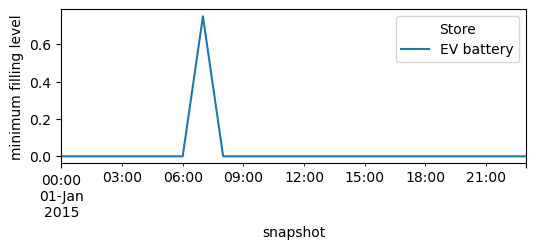

In [226]:
minimum_filling_level = pd.read_csv('data/EV_minimum_filling_level.csv',sep=';')
minimum_filling_level.index = pd.DatetimeIndex(minimum_filling_level['utc_time'])

bev_energy = 0.05  # average battery size of 1 EV battery in MWh
bev_dsm_participants = 1  # share of cars that do smart charging

e_nom = number_cars * bev_energy * bev_dsm_participants

n.add(
    "Store",
    "EV battery",
    bus="EV",
    e_cyclic=True,  # state of charge at beginning = state of charge at the end
    e_nom=e_nom,
    e_min_pu=minimum_filling_level['PRT'].values,
)

n.stores_t.e_min_pu.loc["2015-01-01"].plot(figsize=(6, 2), ylabel="minimum filling level")

In [227]:
n.optimize(solver_name="highs")

Index(['electricity', 'EV'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='StorageUnit')
Index(['onwind', 'solar'], dtype='object', name='Generator')
Index(['EV charger'], dtype='object', name='Link')
Index(['EV battery'], dtype='object', name='Store')
Index(['electricity', 'EV'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='StorageUnit')
Index(['onwind', 'solar'], dtype='object', name='Generator')
Index(['EV charger'], dtype='object', name='Link')
Index(['EV battery'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]
INFO:linopy.io: Writing time: 15.64s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 70083 primals, 157683 duals
Objective: 9.56e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:T

('ok', 'optimal')

In [228]:
n.objective / 1e9

9.56175175715903

In [229]:
n.objective/n.loads_t.p_set.sum().sum()

139.8382352507803

In [230]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

Generator
onwind    25.384097
solar     49.400267
Name: p_nom_opt, dtype: float64

In [231]:
n.storage_units.max_hours*n.storage_units.p_nom_opt.div(1e3) #MWh - GWh

StorageUnit
battery storage    86.879119
dtype: float64

The cost of every MWh or electricity generated is lower and this is mainly becuase with the EV battery, the need for static batteries is significantly reduced.

In [232]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

Generator
onwind     8.102658
solar     64.141545
dtype: float64

We can plot the dispatch of electricity from every generator throughout January 1st.

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16'),
 Text(17, 0, '17'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '20'),
 Text(21, 0, '21'),
 Text(22, 0, '22'),
 Text(23, 0, '23')]

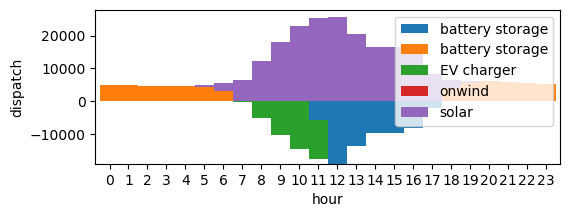

In [233]:
date="2015-07-01"
charge=n.storage_units_t.p['battery storage'][n.storage_units_t.p['battery storage']>0].loc[date]
discharge=n.storage_units_t.p['battery storage'][n.storage_units_t.p['battery storage']<0].loc[date]
EV_charge=n.links_t.p1['EV charger'].loc[date]
combined =  pd.concat([discharge, charge, EV_charge, n.generators_t.p.loc[date],], axis=1)
ax = combined.plot.bar(figsize=(6, 2), ylabel="dispatch", xlabel="hour", stacked=True, width=1)
ax.legend(loc='upper right')
ax.set_xticks(range(len(combined.index)))  
ax.set_xticklabels(combined.index.hour, rotation=0) 

**c) Assume that the EV batteries can also discharge into the grid. How do the required capacities change relative to section (a)? Plot the energy generation and demand throughout July 1st.**

We can also allow vehicle-to-grid operation (i.e. electric vehicles can inject power back into the grid)

In [234]:
p_nom = number_cars * bev_charger_rate

n.add(
    "Link",
    "V2G",
    bus0="EV",
    bus1="electricity",
    p_nom=p_nom,
    p_max_pu=EV_availability_profile['PRT'].values,
    efficiency=0.9,
    overwrite=True,
)


Index(['V2G'], dtype='object', name='Link')

In [235]:
n.optimize(solver_name="highs")

Index(['electricity', 'EV'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='StorageUnit')
Index(['onwind', 'solar'], dtype='object', name='Generator')
Index(['EV charger', 'V2G'], dtype='object', name='Link')
Index(['EV battery'], dtype='object', name='Store')
Index(['electricity', 'EV'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='StorageUnit')
Index(['onwind', 'solar'], dtype='object', name='Generator')
Index(['EV charger', 'V2G'], dtype='object', name='Link')
Index(['EV battery'], dtype='object', name='Store')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]
INFO:linopy.io: Writing time: 19.81s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 78843 primals, 175203 duals
Objective: 9.16e+09
Solver model: available
Solver message: optimal

INFO:pypsa.optimizat

('ok', 'optimal')

In [236]:
n.objective / 1e9

9.158836322935038

In [237]:
n.objective/n.loads_t.p_set.sum().sum()

133.945697491159

In [238]:
n.generators.p_nom_opt.div(1e3)  # MW -> GW

Generator
onwind    42.671041
solar     61.084516
Name: p_nom_opt, dtype: float64

In [239]:
n.storage_units.max_hours*n.storage_units.p_nom_opt.div(1e3) #MWh - GWh

StorageUnit
battery storage    32.807409
dtype: float64

Similarly to section b, here the cost of every MWh or electricity generated is even lower and this is mainly because with the EV batteries allowing discharging back into the grid (vehicle-to-grid), the need for static batteries is further reduced.

The cost of every MWh or electricity generated is lower and this is mainly becuase with the EV battery, the need for static batteries is significantly reduced

In [240]:
n.generators_t.p.sum().div(1e6)  # MWh -> TWh

Generator
onwind     7.318526
solar     66.271000
dtype: float64

We can plot the dispatch of electricity from every generator throughout January 1st.

[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4'),
 Text(5, 0, '5'),
 Text(6, 0, '6'),
 Text(7, 0, '7'),
 Text(8, 0, '8'),
 Text(9, 0, '9'),
 Text(10, 0, '10'),
 Text(11, 0, '11'),
 Text(12, 0, '12'),
 Text(13, 0, '13'),
 Text(14, 0, '14'),
 Text(15, 0, '15'),
 Text(16, 0, '16'),
 Text(17, 0, '17'),
 Text(18, 0, '18'),
 Text(19, 0, '19'),
 Text(20, 0, '20'),
 Text(21, 0, '21'),
 Text(22, 0, '22'),
 Text(23, 0, '23')]

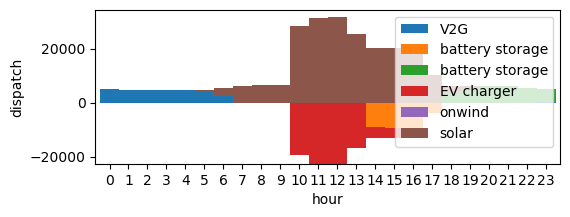

In [241]:
date="2015-07-01"
charge = n.storage_units_t.p['battery storage'][n.storage_units_t.p['battery storage']>0].loc[date]
discharge = n.storage_units_t.p['battery storage'][n.storage_units_t.p['battery storage']<0].loc[date]
EV_charge = n.links_t.p1['EV charger'].loc[date]
EV_discharge = -n.links_t.p1['V2G'].loc[date]
combined =  pd.concat([EV_discharge, discharge, charge, EV_charge, n.generators_t.p.loc[date],], axis=1)
ax = combined.plot.bar(figsize=(6, 2), ylabel="dispatch", xlabel="hour", stacked=True, width=1)
ax.legend(loc='upper right')
ax.set_xticks(range(len(combined.index)))  
ax.set_xticklabels(combined.index.hour, rotation=0)  